In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import ast
import os
import os.path
import scipy.stats as sts
import dicom
import operator
from functools import reduce
from datetime import datetime

ModuleNotFoundError: No module named 'dicom'

In [ ]:
def plot_rt(data):

    fig = plt.figure(facecolor='white')
    ax = plt.axes(frameon=True)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.hist(np.array(data['rt'])/1000,30)

    ax.set_xlim(0,15), ax.set_xticks(np.arange(0,16,3))
    ax.set_yticks([])

    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')

    ax.set_xlabel('Response time')
    ax.axvline(x=15, color='k', linewidth = 2, linestyle = 'dashed')

    plt.show()

In [ ]:
def get_timestamp(direc,a,b):
    fname = direc + str(a) + '-' + str(b) + '-1.dcm/' + str(a) + '-' + str(b) + '-1.dcm'
    ds = dicom.read_file(fname)
    return 1000*datetime.timestamp(datetime.strptime(ds.AcquisitionDate + ds.AcquisitionTime[0:6], "%Y%m%d%H%M%S")) + int(ds.AcquisitionTime[7:10])

def get_all_timestamps(direc,epi_list):    
    n_measurements = dict([[i,sum(1 for f in os.listdir(direc)
                          if f.endswith(".dcm") and f.startswith(str(i)))] for i in epi_list])
    print(direc,n_measurements)
    return [[get_timestamp(direc,i,n) for n in range(1,n_measurements[i])] for i in epi_list]

def pulses_per_run(p,measurements):
    x = np.cumsum([0] + measurements)
    return [p[a:b] for a,b in zip(x[:-1],x[1:])]

def isint(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def get_runs(direc,runtype,name = None):
    if name is None:
        return [get_runs(direc,runtype,name) for name in fmri_names]
    else:
        run_ids = [f.split("-")[0] for f in os.listdir(direc + name + '/NII/') 
               if f.endswith(runtype + ".nii.gz")]
        return list(np.sort(np.unique([int(r) for r in run_ids if isint(r)])))
    
def combine_blocks(ts,i):
    n = round((ts[i+1][0] - ts[i][-1])/2000)
    return sum([ts[i][:-1],
                list(np.linspace(ts[i][-1],ts[i+1][0],num=n+1,dtype='int64')),
                ts[i+1][1:]],[])

def fix_omitted_timestamps(ts,i):
    return ts[:i] + [combine_blocks(ts,i)] + ts[i+2:]

In [2]:
def get_times(i,event_type):
    if data_console[i]==[]:
        return [int(d['time']) for d in data_db[i] 
                if 'type' in d and d['type'].startswith(event_type)]
    else:
        return [int(line[-14:-1]) for line in data_console[i] 
                if line.startswith("Freechoice.js:36 " + event_type +": ")]

def filter_into_runs_no_offset(i,event_times,event_info = []):
    if event_info==[]:
        return [[et for et in event_times 
                 if et>ts_beh[0] and et<ts_beh[-1]] 
                for ts_beh,toff,ts_mri in zip(ts_per_run_behavior[i],t_offset[i],ts_per_run_fmri[i])]    
    
def filter_into_runs(i,event_times,event_info = []):
    if fmri_names[i] in ['Gomoku_01092018_10am-0109-1041','Gomoku_12_06082017_10am-0608-1026']:
        slack=32000
    elif fmri_names[i]=='Gomoku_6_05312017-0531-1508':
        slack=15000
    else:
        slack=0
    if event_info==[]:
        return [[(et+toff-ts_mri[0])/1000 for et in event_times 
                 if et>ts_beh[0]-slack and et<ts_beh[-1]] 
                for ts_beh,toff,ts_mri in zip(ts_per_run_behavior[i],t_offset[i],ts_per_run_fmri[i])]
    else:
        return [[[(et+toff-ts_mri[0])/1000]+list(e) for et,e in zip(event_times,event_info) 
                 if et>ts_beh[0]-slack and et<ts_beh[-1]] 
                for ts_beh,toff,ts_mri in zip(ts_per_run_behavior[i],t_offset[i],ts_per_run_fmri[i])]

def get_rt(i):
    trial_start_times = get_times(i,"load game")
    rt = [int(d['rt']) for d in data_db[i] if 'rt' in d]
    ts = [int(d['ts']) for d in data_db[i] if 'rt' in d]
    return [r for r,t in zip(rt,ts) if t>trial_start_times[0] and t<trial_start_times[-1]]
    
def get_npieces(i):
    trial_start_times = get_times(i,"load game")
    npieces = [len(d['bp'].split('1'))+len(d['wp'].split('1'))-2 
               for d in data_db[i] if 'bp' in d and 'wp' in d]
    ts = [int(d['ts']) for d in data_db[i]
          if 'bp' in d and 'wp' in d]
    return [n for n,t in zip(npieces,ts) if t>trial_start_times[0] and t<trial_start_times[-1]]

def get_trial_order(i):
    #return [list(ast.literal_eval(d['type'][12:])) for d in data_db[i] 
    #     if 'type' in d.keys() and d['type'].startswith('Trial order:')]
    return [int(d['type'][9:]) for d in data_db[i] 
           if 'type' in d and d['type'].startswith("load game")][-217:-1]

def write_regressor(i,name,times,durations=[],values=[]):
    if durations!=[]:
        durations = [d/1000 for d in durations]
        if values!=[]:
            filtered_data = filter_into_runs(i,times,list(zip(durations,values)))
        else: 
            filtered_data = filter_into_runs(i,times,[[d] for d in durations])
    else:
        if values!=[]:
            filtered_data = filter_into_runs(i,times,list(zip([0 for t in times],values)))
            print(list(zip([0 for t in times],values)))
        else: 
            filtered_data = filter_into_runs(i,times)
    for j,f in enumerate(filtered_data):
                np.savetxt(direc + "regressors/" + name +"_times_" + str(i+1) + "_" + str(j+1) + ".txt",
                           np.array(f),fmt='%3.3f')
        
def get_values_from_array(i,arr):
    x = [arr[int(d['type'][9:])] for d in data_db[i] if 'type' in d and d['type'].startswith("load game")]
    ts = [int(d['time']) for d in data_db[i] if 'type' in d and d['type'].startswith("load game")]
    return [xx for xx,t in zip(x,ts) if t>ts_per_run_behavior[i][0][0] and t<ts_per_run_behavior[i][-1][-1]]

def get_highlights(i,s=-1):
    if s==-1:
        return sorted(sum([get_highlights(i,s) for s in range(0,36)],[]), key=lambda x: x[0])
    else:
        tile_clicks = get_times(i,"Tile Clicked")
        time_outs = get_times(i,"Time out")
        pauses = get_times(i,"pause")
        onsets = [d[2] for d in data_output[i]["highlights"] if d[0]=="on" and d[1]==s] 
        offsets = [d[2] for d in data_output[i]["highlights"] if d[0]=="off" and d[1]==s]
        durations = [min([e-o for e in offsets+tile_clicks+time_outs if e>o]) 
                     for o in onsets]
        return list(zip(onsets,durations))

In [3]:
def get_run_data(name):
    filename = direc + "fmri_run_data_" + name + ".csv"
    try:
        with open(filename, 'r') as csvfile:
            fmri_run_data = list(csv.reader(csvfile, delimiter=',', quotechar='"'))
            epis = [int(r) for r in fmri_run_data[0]]
            ts = [ast.literal_eval(r) for r in fmri_run_data[-1]]
    except OSError:
        print('File not found: ', filename)
    return [epis,ts]

In [4]:
fmri_names = ['Gomoku_0_05232017-0523-1612',
'Gomoku_1_05242017-0524-1017',
'Gomoku_2_05242017-0524-1622',
'Gomoku_4_05302017-0530-1621',
'Gomoku_5_05312017-0531-1018',
'Gomoku_6_05312017-0531-1508',
'Gomoku_7_06012017-0601-1302',
'Gomoku_7_06012017-0601-1530',
'Gomoku_9_06062017_10am-0606-1031',
'Gomoku_10_06062017_430pm-0606-1703',
'Gomoku_11_06072017_10am-0607-1018',
'Gomoku_12_06082017_10am-0608-1026',
'Gomoku_10112017_3pm-1011-1558',
'Gomoku_10122017_1pm-1012-1318',
'Gomoku_10172017_430pm-1017-1644',
'Gomoku_10202017_1pm-1020-1306',
'Gomoku_11272017_12pm-1127-1228',
'Gomoku_11282017_12pm-1128-1224',
'Gomoku_11282017_3pm-1128-1509',
'Gomoku_11292017_11am-1129-1122',
'Gomoku_11292017_3pm-1129-1534',
'Gomoku_11302017_4pm-1130-1635',
'Gomoku_12012017_9am-1201-0934',
'Gomoku_12012017_12pm-1201-1230',
'Gomoku_12012017_3pm-1201-1538',
'Gomoku_12042017_9am-1204-0949',
'Gomoku_01092018_10am-0109-1041',
'Gomoku_01092018_3pm-0109-1523',
'Gomoku_01112018_1pm-0111-1324',
'Gomoku_01112018_330pm-0111-1619',
'Gomoku_01242018_10am-0124-1100',
'Gomoku_02072018_10am-0207-1032',
'Gomoku_02092018_4pm-0209-1626',
'Gomoku_02192018_10am-0219-1030',
'Gomoku_02212018_1230-0221-1246',
'Gomoku_02212018_3pm-0221-1512',
'Gomoku_02232018_10am-0223-1021',
'Gomoku_02232018_1230-0223-1255',
'Gomoku_02232018_3pm-0223-1515']

behavior_names = ['XY_05232017', 'NG_05242017', 'NK_05242017', 'DN_05302017', 'MS_05312017','ST_05312017',
                  'CU_06012017', 'AM_06012017', 'EA_06062017', 'CM_06062017', 'LC_06072017', 'TP_06082017',
                  'TC_10112017', 'CF_10122017', 'VS_10172017', 'NP_10202017', 'MH_11272017', 'DB_11282017',
                  'RR_11282017', 'EL_11292017', 'VD_11292017', 'JS_11302017', 'HR_12012017', 'MA_12012017',
                  'FD_12012017','CS_12042017','KD_01092018','IR_01092018','AA_01112018','AM2_01112018',
                  'HZ_01242018','DA_02072018','CV_02092018','MS2_02192018','EC_02212018','TB_02212018',
                  'JW_02232018','LL_02232018','KL_02232018']

behavior_names_short = [name.split('_')[0] for name in behavior_names]

N = len(behavior_names)

direc = 'D:/Bas/Documents/fMRI/Data/Behavior/'
fmri_direc = 'E:/Gomoku_imaging_data/'


In [5]:
fmri_epi_runs, ts_per_run_fmri = zip(*[get_run_data(name) for name in fmri_names])
n_runs = [len(r) for r in fmri_epi_runs]
measurements_per_run_fmri = [[len(s) for s in t] for t in ts_per_run_fmri]

File not found:  D:/Bas/Documents/fMRI/Data/Behavior/fmri_run_data_Gomoku_0_05232017-0523-1612.csv


UnboundLocalError: local variable 'epis' referenced before assignment

In [12]:
data_output = [json.load(open(direc + 'FreechoiceData' + name + '.txt')) for name in behavior_names]
data_db = [json.load(open(direc + 'Database' + name + '.json')) for name in behavior_names_short]

fnames = [direc + "console" + name + ".log" for name in behavior_names]
data_console = [open(name,"r").readlines() if os.path.isfile(name) else [] for name in fnames]

In [13]:
pulses = [d["pulses"] for d in data_output]

measurements_per_run_behavior = [[x for x in np.diff(np.append([-1],np.nonzero(np.diff(p+[np.infty])>2500)))
                       if x>1] for p in pulses]
ts_per_run_behavior = [pulses_per_run(p,m) 
                       for p,m in zip(pulses,measurements_per_run_behavior)]

ts_per_run_behavior[3] = fix_omitted_timestamps(ts_per_run_behavior[3],1)
ts_per_run_behavior[4] = fix_omitted_timestamps(ts_per_run_behavior[4],6)
ts_per_run_behavior[4] = fix_omitted_timestamps(ts_per_run_behavior[4],0)
ts_per_run_behavior[6] = fix_omitted_timestamps(ts_per_run_behavior[6],2)
ts_per_run_behavior[13] = fix_omitted_timestamps(ts_per_run_behavior[13],2)
ts_per_run_behavior[31] = ts_per_run_behavior[31][1:]

measurements_per_run_behavior = [[len(s) for s in t] for t in ts_per_run_behavior]

In [16]:
fmri_epi_runs

([3, 5, 7, 9],
 [3, 5, 7, 9],
 [3, 5, 7, 9],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13, 15],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [9, 11, 13, 15, 17, 19],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [11, 13, 15, 17, 19, 21],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13],
 [3, 5, 7, 9, 11, 13])

In [19]:
measurements_per_run_fmri

[[319, 325, 332, 336],
 [332, 331, 333, 334],
 [334, 349, 348, 337],
 [338, 336, 346, 359, 334, 336],
 [335, 331, 338, 335, 354, 341],
 [335, 332, 337, 335, 338, 359, 152],
 [344, 337, 335, 329, 337, 333],
 [329, 338, 342, 340, 359, 354],
 [331, 332, 339, 336, 337, 337],
 [336, 335, 338, 335, 331, 331],
 [333, 337, 331, 336, 333, 332],
 [318, 334, 337, 333, 338, 337],
 [340, 359, 334, 338, 346, 337],
 [332, 336, 339, 338, 345, 341],
 [334, 337, 343, 337, 332, 335],
 [337, 339, 350, 335, 338, 339],
 [341, 340, 342, 337, 338, 338],
 [341, 337, 336, 332, 359, 333],
 [328, 336, 339, 337, 340, 337],
 [340, 342, 344, 346, 337, 336],
 [337, 342, 339, 336, 334, 338],
 [332, 340, 337, 338, 337, 343],
 [345, 340, 343, 342, 339, 332],
 [337, 333, 334, 336, 338, 331],
 [337, 331, 339, 338, 339, 328],
 [341, 339, 336, 332, 337, 336],
 [319, 349, 334, 349, 339, 349],
 [334, 329, 351, 338, 340, 339],
 [343, 344, 329, 341, 346, 338],
 [341, 334, 337, 341, 335, 344],
 [336, 337, 328, 332, 331, 331],
 [

In [22]:
#fmri_epi_runs = [list(filter(lambda x: x%2,runs)) 
#                 for runs in get_runs(fmri_direc,"epiSRacc3moco2mm0gap")]

#ts_per_run_fmri = [get_all_timestamps(fmri_direc + name + "/dcm/",r) 
#                   for name,r in zip(fmri_names,fmri_epi_runs)]

#measurements_per_run_fmri = [[len(s) for s in t] for t in ts_per_run_fmri]


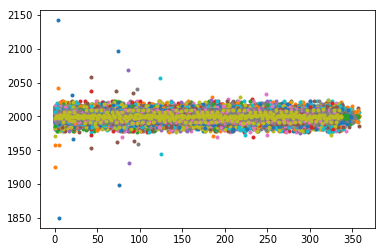

In [23]:
for ts in ts_per_run_behavior:
    for t in ts:
        plt.plot(np.diff(t),'.')
plt.show()

In [20]:
len(measurements_per_run_fmri)

39

In [21]:
excess_runs = [len(measurements_per_run_behavior[i])-len(measurements_per_run_fmri[i]) 
               for i in range(N)]

excess = [np.array(measurements_per_run_behavior[i])- np.array(measurements_per_run_fmri[i]) 
          if excess_runs[i]==0 else str(excess_runs[i])+" more run" + ("s" if excess_runs[i]>1 else "") 
          for i in range(N)]

excess

[array([2, 2, 2, 2]),
 array([2, 2, 2, 2]),
 array([3, 2, 2, 2]),
 array([3, 2, 2, 1, 2, 2]),
 array([2, 2, 3, 2, 2, 2]),
 array([2, 3, 2, 2, 3, 1, 2]),
 array([3, 2, 2, 3, 2, 2]),
 array([2, 2, 2, 2, 1, 2]),
 array([2, 2, 3, 2, 2, 2]),
 array([3, 2, 2, 2, 2, 3]),
 array([2, 2, 2, 2, 3, 3]),
 array([3, 2, 2, 2, 2, 2]),
 array([3, 1, 2, 2, 2, 2]),
 array([2, 3, 2, 2, 2, 2]),
 array([2, 3, 2, 2, 2, 3]),
 array([ -3,  -3, -12,  -2,  -1,  -3]),
 array([2, 3, 2, 2, 3, 3]),
 array([2, 3, 2, 3, 1, 2]),
 array([2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 3, 2, 3]),
 array([2, 2, 2, 2, 2, 2]),
 array([3, 3, 2, 2, 2, 2]),
 array([2, 3, 2, 2, 2, 3]),
 array([2, 2, 2, 2, 2, 2]),
 array([3, 2, 2, 2, 3, 2]),
 array([2, 2, 3, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 3, 2, 2]),
 array([2, 2, 2, 2, 2, 2]),
 array([2, 2, 3, 2, 2, 2]),
 array([2, 2, 2, 2, 3, 2]),
 array([2, 2, 2, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2]),
 array([2, 3, 3, 2, 2, 2]),
 array([2, 2, 2, 2, 2, 2]),
 array([2, 3, 2, 2, 3, 

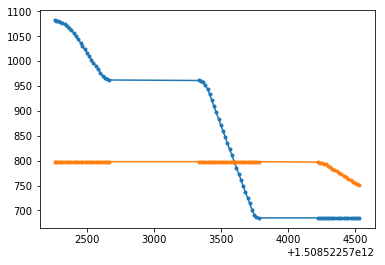

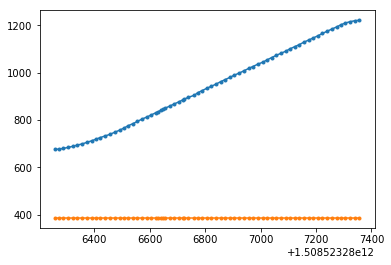

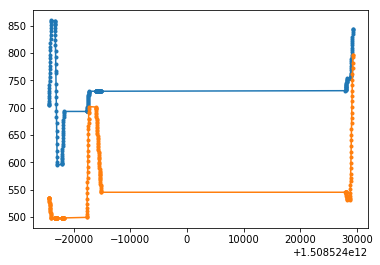

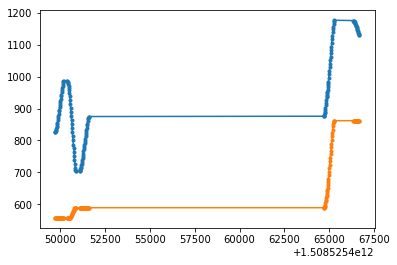

In [26]:
trial_times = [int(ast.literal_eval(line[line.find('{'):line.find('}')+1])['ts'])
 for line in data_console[15] if line.startswith('Freechoice.js:199 response submitted')]
 
for t1,t2 in zip(trial_times[35::36],trial_times[36::36]):
    mc = np.array([x for x in data_output[15]['mousecoords'] if x[0]>=t1 and x[0]<=t2])
    if np.prod(mc.shape)>0:
        plt.plot(mc[:,0],mc[:,1:],'.-')
        plt.show()

In [27]:
measurements_per_run = [[min(mm1,mm2) for mm1,mm2 in zip(m1,m2)] for m1,m2 in zip(measurements_per_run_behavior,measurements_per_run_fmri)]

t_offset = [[np.mean(np.array(ts_per_run_fmri[i][j][:n])-np.array(ts_per_run_behavior[i][j][:n]))
            for j,n in zip(range(n_runs[i]),measurements_per_run[i])] if(excess_runs[i]==0) else []
            for i in range(N)]

In [28]:
i=5
event_times = get_times(i,"load game")
filtered_times = filter_into_runs_no_offset(i,event_times)
print(fmri_names[i])
print(set(event_times)-set(sum(filtered_times,[])))
print(event_times[199]-ts_per_run_behavior[5][5][-1])
print(ts_per_run_behavior[5][6][0]-event_times[199])

Gomoku_6_05312017-0531-1508
{1496263829672, 1496263140077}
16315
13778


In [29]:
i=11
event_times = get_times(i,"load game")
filtered_times = filter_into_runs_no_offset(i,event_times)
print(fmri_names[i])
print(set(event_times)-set(sum(filtered_times,[])))
print(ts_per_run_behavior[i][0][0] - event_times[0])
print(ts_per_run_behavior[i][0][0] - event_times[1])

Gomoku_12_06082017_10am-0608-1026
{1496932458245, 1496932440203, 1496937316445}
27961
9919


In [30]:
i=26
event_times = get_times(i,"load game")
filtered_times = filter_into_runs_no_offset(i,event_times)
print(fmri_names[i])
print(set(event_times)-set(sum(filtered_times,[])))
print(ts_per_run_behavior[i][0][0] - event_times[0])
print(ts_per_run_behavior[i][0][0] - event_times[1])

Gomoku_01092018_10am-0109-1041
{1515512943322, 1515517499962, 1515512962851}
31065
11536


In [31]:
#data1 = data1[np.logical_and(data1['response']!=99,data1['status']!="ready")]
#data1['player_id']=data1['user_name'].map(dict(zip(names,range(len(names))))).astype(int)
#data=pd.concat([data1,data2])

#data.to_csv('C:/Users/Bas/Google Drive/Bas Games/Freechoice_data.txt',
#                               sep=',', columns = ['player_id','color','bp','wp','response','rt'],
#                               header=None, index=False)

In [72]:
#get_runs("E:/Gomoku_imaging_data/","localizer")

In [73]:
#get_runs("E:/Gomoku_imaging_data/","MPRAGEtflCMU")

In [74]:
#get_runs("E:/Gomoku_imaging_data/","epiSRacc3moco2mm0gap")

In [75]:
#get_runs("E:/Gomoku_imaging_data/","ep2dseAP")

In [76]:
#get_runs("E:/Gomoku_imaging_data/","ep2dsePA")

In [77]:
#model_direc = 'C:/Users/Bas/Google Drive/Bas Games/'
#ind = np.loadtxt(model_direc + 'fmri_board_inds.txt').astype(int)

#F=np.loadtxt(model_direc + 'fmri_regressors.txt')
#F=np.vstack((np.tanh(F[:,3]/20),np.mean(np.tanh(F[:,4:]/20),axis=1)))
#val = [np.mean(F[1,i::5482]) for i in ind]

In [190]:
model_direc = 'C:/Users/Bas/Google Drive/Bas Games/'
val = np.mean(np.tanh(np.loadtxt(model_direc + 'fmri_board_values.txt')/20),axis=0)
hval = np.mean(np.tanh(np.loadtxt(model_direc + 'fmri_board_heur_values.txt')/20),axis=0)

features = np.loadtxt(model_direc + 'fmri_feature_values.txt')
npieces = np.loadtxt(model_direc + 'fmri_npieces.txt')

val = val*features[:,0]
hval = hval*features[:,0]

features = features[:,1:]*features[:,0][:,None]
fcenter = features[:,0]
f2conn = np.sum(features[:,[1,5,9,13]],axis=1)-np.sum(features[:,[18,22,26,30]],axis=1)
f2unc = np.sum(features[:,[2,6,10,14]],axis=1)-np.sum(features[:,[19,23,27,31]],axis=1)
f3inarow = np.sum(features[:,[3,7,11,15]],axis=1)-np.sum(features[:,[20,24,28,32]],axis=1)
ftriangle = features[:,17]-features[:,34]
#features = features[:,np.sum(np.abs(features),axis=0)>20]
#np.sum(np.abs(features),axis=0)

C:\Users\Bas\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Bas\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


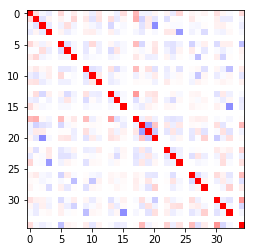

In [80]:
plt.imshow(np.corrcoef(features.T),interpolation='nearest',vmin = -1, vmax =1, cmap='bwr')
plt.show()

In [81]:

dt=250

from matplotlib.colors import LogNorm

all_vars = np.zeros(shape=(6,0))

for i in range(3,N):
    
    print(i)
    write_regressor(i,"tile_click",get_times(i,"Tile Clicked"))
    
    
    write_regressor(i,"trial_id",get_times(i,"load game"),get_trial_order(i))
    
    npieces = get_npieces(i)
    rt = get_rt(i)
    tstart = get_times(i,"load game")[:-1]
    dafter = [1500 for t in rt]
    nafter = [n+1 for n in npieces]
    tafter = [t + d for t,d in zip(tstart,rt)]
    write_regressor(i,"npieces",tstart+tafter,durations = rt+dafter,values = npieces + nafter)
    write_regressor(i,"npiecesmod2",tstart+tafter,durations = rt+dafter,
                    values = [n%2 for n in npieces + nafter])

    for n in [5,4,3,2,1]:
        twarning = [t+15000-n*1000 for t,r in zip(tstart,rt) if r+n*1000>15000]
        dwarning = [min(r+n*1000-15000,1000) for r in rt if r+n*1000>15000]
        write_regressor(i,"setwarning" + str(n),twarning,durations = dwarning)

    ttimeout = [t+15000 for t,r in zip(tstart,rt) if r>15000]
    dtimeout = [1500 for t in ttimeout]
    itimeout = [1 for t in ttimeout]
    write_regressor(i,"time_out",ttimeout,durations = dtimeout,values = itimeout)
    
    tboard_shown = tstart
    dboard_shown = [r+1000 for r in rt]
    write_regressor(i,"board_shown",tstart,durations = dboard_shown)
    
    trajectory = np.array(data_output[i]['mousecoords'])
    ts = np.arange(min(trajectory[:,0]),max(trajectory[:,0]),dt)
    x = np.interp(ts,trajectory[:,0],trajectory[:,1])
    vx = np.gradient(x,ts)*dt
    ax = np.gradient(vx,ts)*dt
    y = np.interp(ts,trajectory[:,0],trajectory[:,2])
    vy = np.gradient(y,ts)*dt
    ay = np.gradient(vy,ts)*dt
    
    all_vars = np.hstack([all_vars,np.vstack([x,y,vx,vy,ax,ay])])        
    write_regressor(i,"squared_velocity",ts,durations = [dt for t in ts], values = vx**2 + vy**2)
    write_regressor(i,"joystick_vx",ts,durations = [dt for t in ts], values = vx)
    write_regressor(i,"joystick_ax",ts,durations = [dt for t in ts], values = ax)
    write_regressor(i,"joystick_vy",ts,durations = [dt for t in ts], values = vy)
    write_regressor(i,"joystick_ay",ts,durations = [dt for t in ts], values = ay)
        
plt.hist2d(all_vars[0],all_vars[1], bins=50,norm=LogNorm(),cmap='inferno_r')
plt.show()
plt.hist2d(all_vars[2],all_vars[3], bins=50,norm=LogNorm(),cmap='inferno_r')
plt.show()
plt.hist2d(all_vars[4],all_vars[5], bins=50,norm=LogNorm(),cmap='inferno_r')
plt.show()



3


C:\Users\Bas\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


KeyboardInterrupt: 

In [32]:
def load_motions(r,name):
    fname = 'D:/Bas/Documents/fMRI/analysis/motions/' + name + '_rp_' + str(r) + '-1-1epiSRacc3moco2mm0gap.txt'
    try:
        return np.loadtxt(fname)
    except OSError:
        print('file not found:',fname)
        return None

In [54]:
def get_upper_lower_bounds(motions,i):
    d = np.hstack([np.hstack([mm[:,i] for mm in m]) for m in motions])
    return [np.percentile(d,1),np.percentile(d,99)]

def plot_motions(fig,ax,k):
    for i in range(3):
        for j in range(2):
            ax[j][i].plot(np.vstack(motions[k])[:,i+3*j]/ave_motion[i+3*j])
            ax[j][i].set_ylim([-10,10])
            
def get_cdf(x,bins):
    return np.cumsum(np.histogram(x,bins=bins)[0])/len(x)

In [36]:
import scipy.signal as signal

motions = [[np.diff(load_motions(r,name),axis=0) for r in runs] 
           for runs,name in zip(fmri_epi_runs,fmri_names)]



In [37]:
M= np.vstack([np.vstack([np.sqrt(np.mean(mm**2,axis=0)) for mm in m]) for m in motions])
ave_motion = np.mean(M,axis=0)
C= np.corrcoef(M.T)
mean_squared_motion = [np.mean([np.sqrt(np.mean(mm**2,axis=0))/ave_motion for mm in m]) for m in motions]

In [56]:
bins = np.arange(0,10,0.001)
cdf = 100*np.array([np.mean([get_cdf(np.hstack([np.abs(mm[:,i])/ave_motion[i] for mm in m]),bins=bins) 
                           for i in range(6)],axis=0) 
                  for m in motions]).T
frac_extreme_thresh = (100-cdf)/np.sum(100-cdf,axis=1)[:,None]

frac_extreme = np.max(frac_extreme_thresh,axis=0)
L = list(np.argsort(frac_extreme))
for n in [0,1,2,15]:
    L.remove(n)
print(np.array(L)+1)
len(L)


[36 34 33  6 39 12 19 31 28  8 14 25  9 24 13  4 37 11 20  5 17 23 18 27 30
 21 38 26 29 35 15 32 10  7 22]


35

[ 6  9 14 21 31 34]


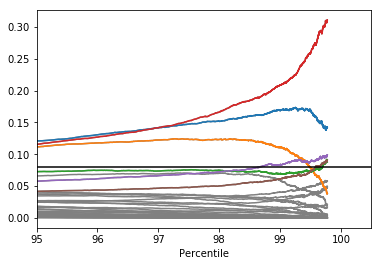

In [57]:
thresh = 0.08
ind_exclude = np.nonzero(frac_extreme>thresh)[0]
print(ind_exclude)

plt.plot(np.mean(cdf,axis=1),frac_extreme_thresh,color='gray')
plt.plot(np.mean(cdf,axis=1),frac_extreme_thresh[:,ind_exclude])
plt.xlabel('Percentile')
plt.axhline(thresh,color='black')
plt.xlim([95,100.5])
plt.show()

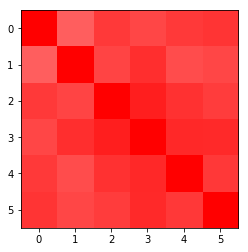

0.834692880577


In [50]:
plt.imshow(C, cmap='bwr',vmin=-1, vmax =1)
plt.show()
print(np.mean(C[np.triu_indices(6)]))

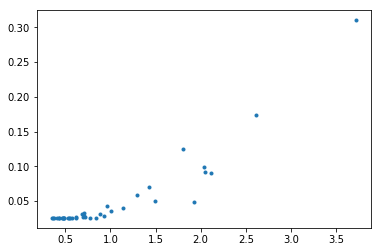

SpearmanrResult(correlation=0.93137651821862344, pvalue=8.0793838677929632e-18)


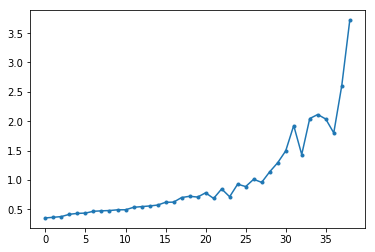

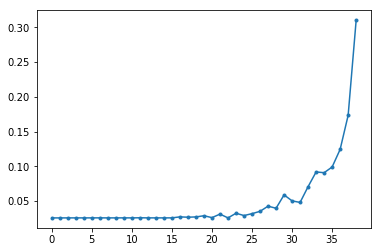

[(33, 'MS2_02192018', 0.02561399546588608, 0.3514090692520167),
 (35, 'TB_02212018', 0.025589418567218598, 0.36190441337890888),
 (38, 'KL_02232018', 0.025632956098430242, 0.37459869298046944),
 (18, 'RR_11282017', 0.025635357713108053, 0.41343103582397772),
 (32, 'CV_02092018', 0.025618864915460948, 0.42847955440038354),
 (7, 'AM_06012017', 0.025639463155751278, 0.43377741527812663),
 (12, 'TC_10112017', 0.025669969511344044, 0.46453899989934971),
 (5, 'ST_05312017', 0.025625477535427019, 0.47202697903505286),
 (30, 'HZ_01242018', 0.02563750918992121, 0.47722984473823327),
 (8, 'EA_06062017', 0.025658254749894232, 0.48954936227391804),
 (0, 'XY_05232017', 0.025625441746853543, 0.49026312985019466),
 (2, 'NK_05242017', 0.025792148574213913, 0.53168132345882668),
 (24, 'FD_12012017', 0.02565112700207323, 0.54398171295577158),
 (13, 'CF_10122017', 0.025645481839092873, 0.55487368438931362),
 (11, 'TP_06082017', 0.025634868848983652, 0.57024197557482237),
 (23, 'MA_12012017', 0.0256616032

In [51]:
ind = np.argsort(np.multiply(mean_squared_motion,0.01+frac_extreme))

plt.plot(mean_squared_motion,frac_extreme,'.')
plt.show()
print(sts.spearmanr(mean_squared_motion,frac_extreme))

plt.plot([mean_squared_motion[i] for i in ind],'.-')
plt.show()

plt.plot([frac_extreme[i] for i in ind],'.-')
plt.show()

[list(zip(range(N),behavior_names,frac_extreme,mean_squared_motion))[i] for i in ind]

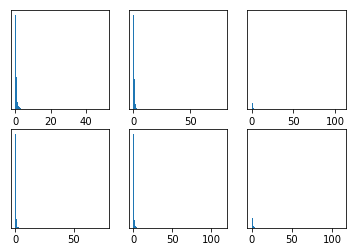

In [52]:
fig,ax = plt.subplots(2,3)
for i in range(3):
    for j in range(2):
        d = np.hstack([np.hstack([np.abs(mm[:,i+3*j])/ave_motion[i+3*j] for mm in m]) for m in motions])
        ax[j][i].hist(d,200)
        ax[j][i].set_yticks([])
plt.show()

MS2_02192018


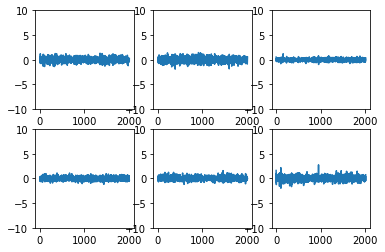

TB_02212018


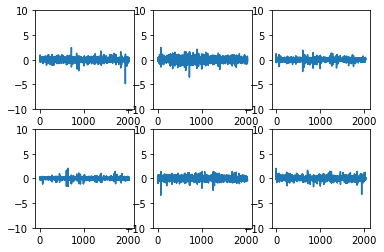

KL_02232018


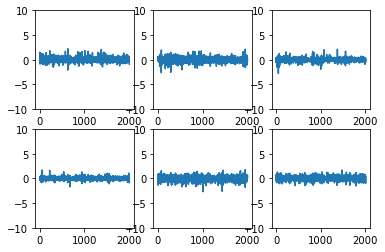

RR_11282017


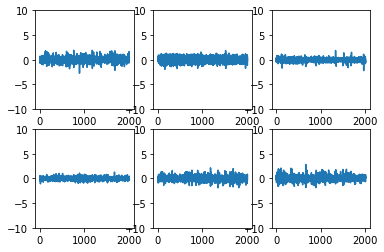

CV_02092018


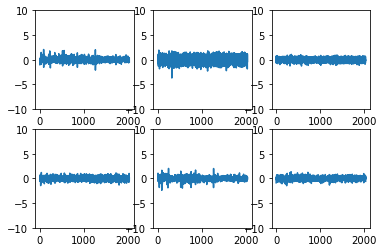

AM_06012017


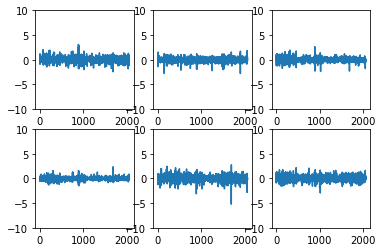

TC_10112017


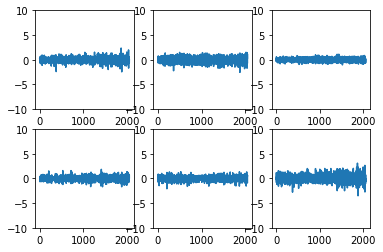

ST_05312017


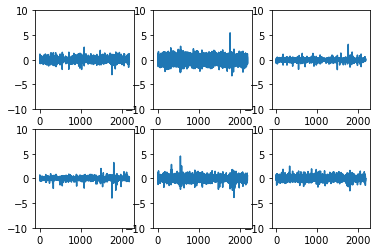

HZ_01242018


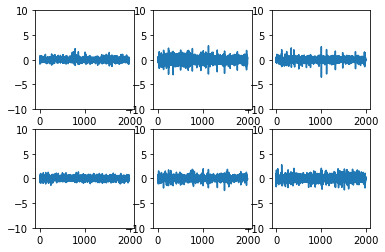

EA_06062017


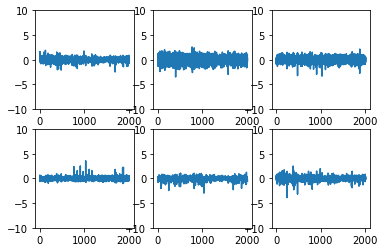

XY_05232017


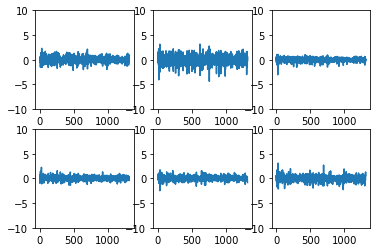

NK_05242017


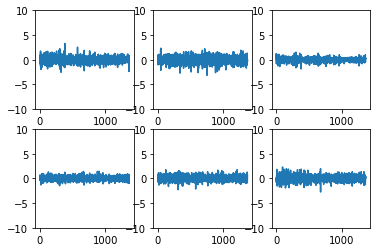

FD_12012017


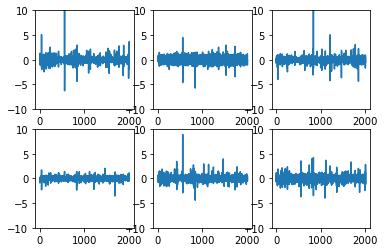

CF_10122017


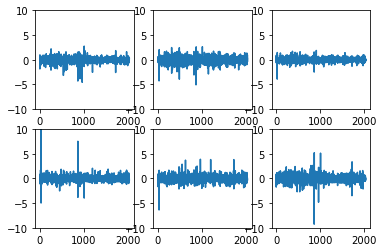

TP_06082017


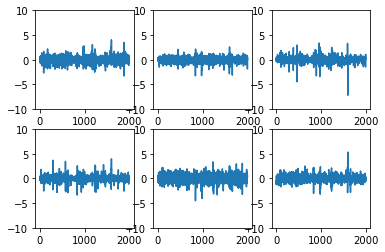

MA_12012017


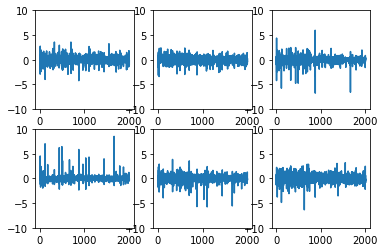

EL_11292017


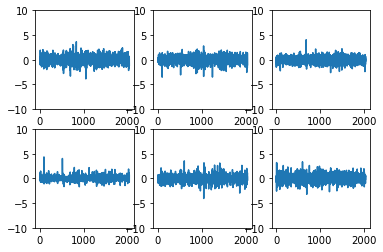

JW_02232018


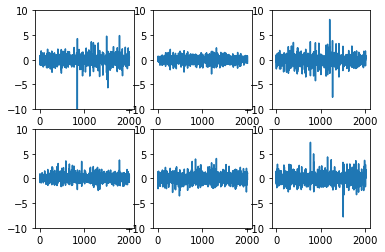

LC_06072017


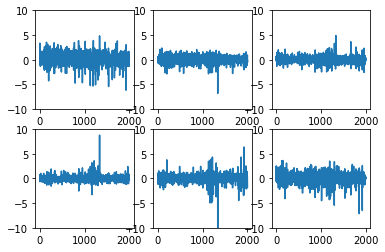

NP_10202017


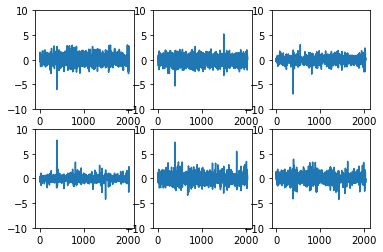

DN_05302017


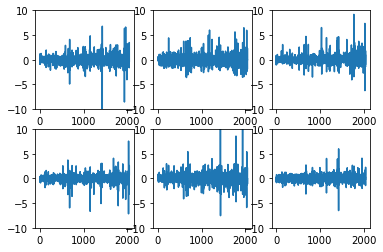

MH_11272017


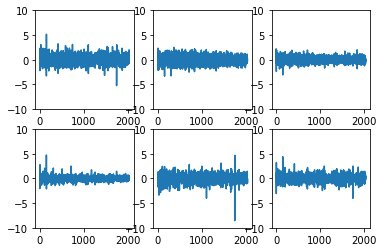

IR_01092018


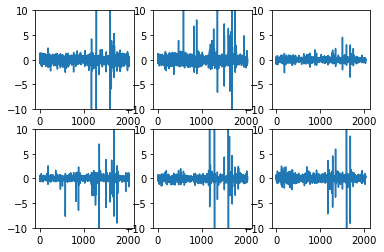

HR_12012017


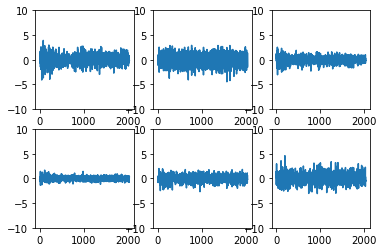

MS_05312017


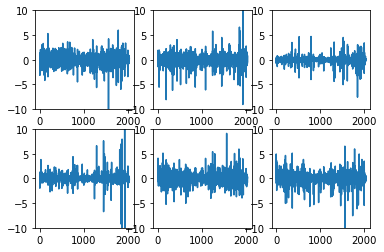

NG_05242017


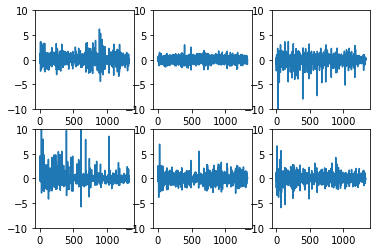

DB_11282017


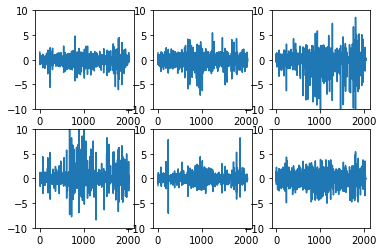

AM2_01112018


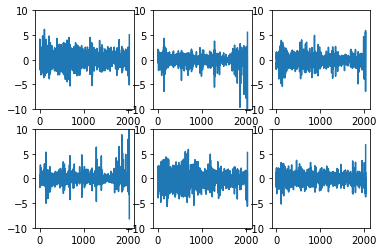

KD_01092018


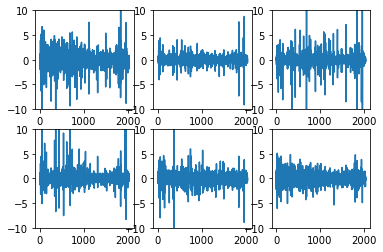

CS_12042017


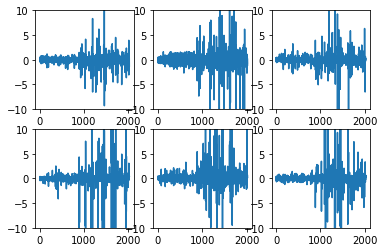

LL_02232018


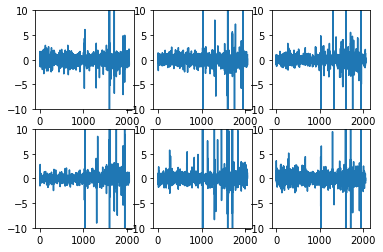

VD_11292017


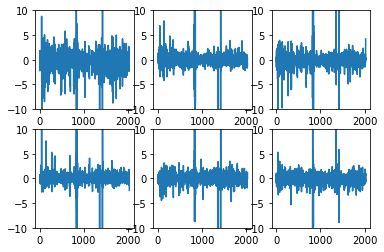

AA_01112018


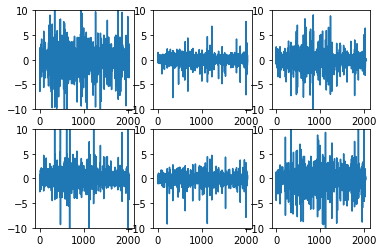

VS_10172017


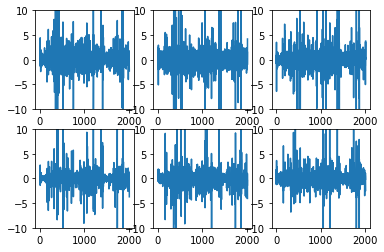

EC_02212018


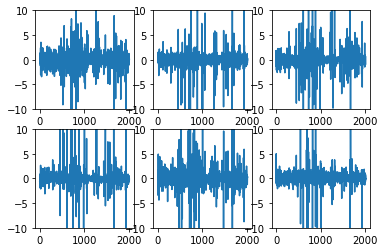

DA_02072018


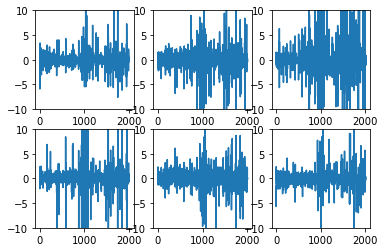

CM_06062017


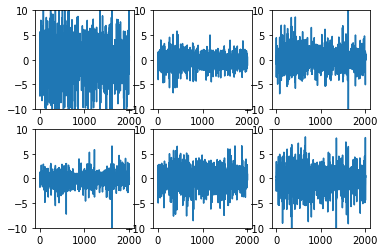

CU_06012017


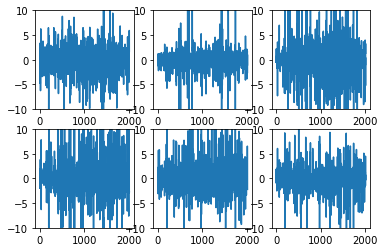

JS_11302017


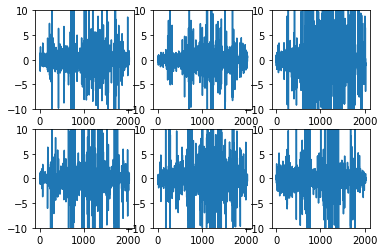

In [55]:
for i in ind:
    fig,ax = plt.subplots(2,3)
    print(behavior_names[i])
    plot_motions(fig,ax,i)
    plt.show()

In [234]:
x = [np.corrcoef(np.abs(get_values_from_array(i,val)),get_rt(i))[0,1] 
 for i in range(3,N) if len(get_values_from_array(i,val))==len(get_rt(i))]
print(np.mean(x),np.std(x)/np.sqrt(np.size(x)))

-0.214371897887 0.019709643637


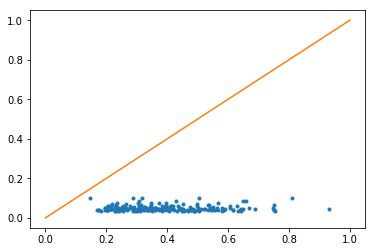

In [174]:
C = np.array([d['choices'] for d in data_output[3:]]).astype(int)
H = [C[C[:,i]!=99,i] for i in range(216)]
pc = [np.sum([x*(x-1) for x in np.histogram(h)[0]])/np.size(h)/(np.size(h)-1) for h in H]
plt.plot(pc,1/(36-np.array(npieces)),'.')
plt.plot([0,1],[0,1])
plt.show()

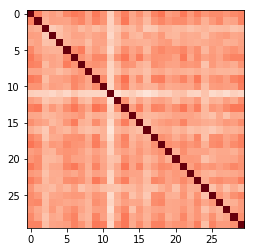

0.361488039175 0.00837212492652


In [227]:
M = np.array([[np.mean([c1==c2 for c1,c2 in zip(C[i,:],C[j,:]) if c1!=99 and c2!=99]) 
               for i in range(C.shape[0])] for j in range(C.shape[0])])
x = M[np.triu_indices(C.shape[0])]

plt.imshow(M,cmap='Reds', vmin=0, vmax =1)
plt.show()

print(np.mean(x),np.std(x)/np.sqrt(np.size(x)))